In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

# Initialize Spark session
spark = SparkSession.builder.appName("MLlibTest").getOrCreate()

# Test MLlib
data = [(1, Vectors.dense([0.0, 1.0, 2.0]), 1.0),
        (2, Vectors.dense([1.0, 2.0, 3.0]), 0.0)]

df = spark.createDataFrame(data, ["id", "features", "label"])
df.show()

+---+-------------+-----+
| id|     features|label|
+---+-------------+-----+
|  1|[0.0,1.0,2.0]|  1.0|
|  2|[1.0,2.0,3.0]|  0.0|
+---+-------------+-----+



In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SpeechEmotionRecognition") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [0]:
%pip install kaggle tensorflow==2.12.0 librosa numpy scikit-learn


Python interpreter will be restarted.
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105803 sha256=8ca2b992e2129c0cb69f17396bf677d9184b49d316f8f3b4c57a548fdc9db5f6
  Stored in directory: /root/.cache/pip/wheels/2b/af/a9/70bffa2773af622d2ebea9c8d407720b86e67bd40c465bf837
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2021.10.8
    Not uninstalling certifi at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f28befdf-b44a-4d10-9206-90b8717a014b
    Can't uninstall 'certifi'. No files were found to uninstall.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f28befdf-b44a-4d10-9206-90b8717a014b
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: scipy


In [0]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kaggle.api.kaggle_api_extended import KaggleApi

# Step 1: Set Kaggle credentials dynamically
os.environ["KAGGLE_USERNAME"] = "akshayakatepally"  # Replace with your Kaggle username
os.environ["KAGGLE_KEY"] = "d50acf27d0c1a1cb14ccf0a38a023aa8"  # Replace with your Kaggle API key

# Step 2: Authenticate with Kaggle
api = KaggleApi()
api.authenticate()

# Step 3: Define datasets and destination paths
datasets = {
    "uwrfkaggler/ravdess-emotional-speech-audio": "/dbfs/temp/ravdess/",
    "ejlok1/toronto-emotional-speech-set-tess": "/dbfs/temp/tess/",
    "ejlok1/cremad": "/dbfs/temp/crema/",
    "ejlok1/surrey-audiovisual-expressed-emotion-savee": "/dbfs/temp/savee/",
}

# Step 4: Download and extract datasets
for dataset_name, destination_path in datasets.items():
    os.makedirs(destination_path, exist_ok=True)  # Ensure the directory exists
    print(f"Downloading {dataset_name}...")
    api.dataset_download_files(dataset_name, path=destination_path, unzip=True)
    print(f"Downloaded and extracted to {destination_path}")

# Step 5: Define paths for all datasets
dataset_paths = list(datasets.values())

file_paths = []
emotions = []

# Define emotion mappings
ravdess_emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

crema_emotion_map = {
    "NEU": "neutral", "HAP": "happy", "SAD": "sad",
    "ANG": "angry", "FEA": "fearful", "DIS": "disgust"
}

savee_emotion_map = {
    "n": "neutral", "h": "happy", "sa": "sad", "a": "angry",
    "f": "fearful", "d": "disgust", "su": "surprised"
}

tess_emotion_map = {
    "neutral": "neutral", "happy": "happy", "sad": "sad",
    "angry": "angry", "fearful": "fearful", "disgust": "disgust",
    "ps": "surprised"
}

# Function to extract emotion from filenames
def extract_emotion_from_filename(file_name, dataset_path):
    if "ravdess" in dataset_path:
        parts = file_name.split("-")
        return ravdess_emotion_map.get(parts[2])  # Extract 3rd part for emotion code
    elif "crema" in dataset_path:
        parts = file_name.split("_")
        return crema_emotion_map.get(parts[2][:3])  # Extract 3rd part for emotion
    elif "savee" in dataset_path:
        emotion_code = file_name.split("_")[0]
        return savee_emotion_map.get(emotion_code)  # First part of file name is emotion code
    elif "tess" in dataset_path:
        parts = file_name.split("_")
        emotion = parts[1].split(".")[0].lower()  # Second part contains emotion
        return tess_emotion_map.get(emotion)

# Step 6: Loop through all datasets to extract file paths and emotions
for dataset_path in dataset_paths:
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion = extract_emotion_from_filename(file, dataset_path)
                if emotion:
                    file_paths.append(file_path)
                    emotions.append(emotion)

# Step 7: Feature extraction
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print("Extracting features...")
features = [extract_features(fp) for fp in file_paths]

# Filter out None values
features = [f for f in features if f is not None]

# Ensure features and emotions lengths match
valid_indices = [i for i, f in enumerate(features) if f is not None]
features_filtered = np.array([features[i] for i in valid_indices])
emotions_filtered = [emotions[i] for i in valid_indices]

# Step 8: Label encoding
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(emotions_filtered)

# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_filtered)

# Step 9: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_normalized, encoded_emotions, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Sample feature: {features_normalized[0] if len(features_normalized) > 0 else 'No features extracted!'}")
print(f"Sample emotion: {emotions_filtered[0] if len(emotions_filtered) > 0 else 'No emotions found!'}")

# Ensure shapes are correct
print(f"Features shape: {features_normalized.shape}")
print(f"Labels shape: {len(encoded_emotions)}")

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
Downloaded and extracted to /dbfs/temp/ravdess/
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
Downloaded and extracted to /dbfs/temp/tess/
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
Downloaded and extracted to /dbfs/temp/crema/
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
Downloaded and extracted to /dbfs/temp/savee/
Extracting features...
Training samples: 8257, Testing samples: 2065
Sample feature: [-1.2692746  -1.0868608  -0.47370875 -1.108657    1.6466271  -0.59917814
  2.8331172  -0.784574    0.72983396  0.67536706  0.78357196  0.89421266
  0.9789022   1.3452636  -0.58755255  1.7183461   0.33420742  1.5054312
 -0.19381234  0.85845244 -0.5139143   0.8899596   0.6797862   0.00529852
  0.523985   -0.25964     0.8466409   0.26703846 -0.2942436  -0.77254117
 -1.2471755  -0.14496075 -1.3142085   

In [0]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Feature extraction 
def extract_features(audio_files):
    features = []
    for file in audio_files:
        audio, sr = librosa.load(file)
        spectrogram = librosa.feature.melspectrogram(audio, sr=sr)
        features.append(spectrogram)
    return np.array(features)


# Step 3: Define the CNN model
height = 128  # Adjust based on your spectrogram size
width = 128
channels = 1  # If the spectrogram is 1 channel, else adjust accordingly.

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 3), activation="relu", input_shape=(1, 40, 1)),
    tf.keras.layers.Conv2D(64, (1, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(len(np.unique(encoded_emotions)), activation="softmax")
])

# Step 4: Compile the model
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])


# Step 5: Summarize the model
model.summary()

# Step 6: Reshape the input data before training
X_train = X_train.reshape(-1, 1, 40, 1)  # Reshaping to (samples, height, width, channels)
X_test = X_test.reshape(-1, 1, 40, 1)    # Same for the test set

# Step 7: Train the model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 38, 32)         128       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 36, 64)         6208      
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 302,408
Trainable params: 302,408
Non-trai

In [0]:
# Predict on a sample
sample_index = 0  # Change this to test different samples

# Reshape for prediction (should be (1, 1, 40, 1))
sample_input = X_test[sample_index].reshape(1, 1, 40, 1)

# Predict the class
predicted_class = np.argmax(model.predict(sample_input))

# Get the actual class
actual_class = y_test[sample_index]

# Print results
print(f"Predicted Emotion: {predicted_class}, Actual Emotion: {actual_class}")


1/1 [==============================] - 0s 79ms/step
Predicted Emotion: 2, Actual Emotion: 2


In [0]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

65/65 [==============================] - 0s 3ms/step - loss: 1.7920 - accuracy: 0.5908
Test Accuracy: 59.08%


In [0]:
# Save the model
model_save_path = "/dbfs/temp/emotion_recognition_model.h5"
model.save(model_save_path)
print(f"Model saved successfully at {model_save_path}")

Model saved successfully at /dbfs/temp/emotion_recognition_model.h5


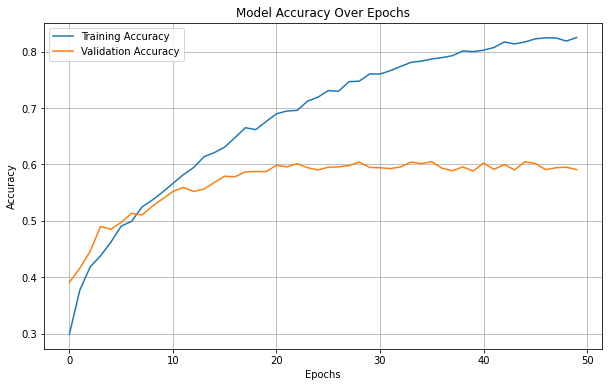

In [0]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [0]:
final_train_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")

final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Final Training Accuracy: 82.51%
Final Validation Accuracy: 59.08%
Test Accuracy: 59.08%


In [0]:
# Save the StandardScaler for later use
import joblib
scaler_save_path = "/dbfs/temp/scaler.pkl"
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved successfully at {scaler_save_path}")

Scaler saved successfully at /dbfs/temp/scaler.pkl


In [0]:
len(np.unique(encoded_emotions))
print(f"Number of emotions: {len(np.unique(encoded_emotions))}")

raw_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
label_encoder = LabelEncoder()
label_encoder.fit(raw_labels)

emotion_classes = label_encoder.classes_
print("Emotions in the dataset:", list(emotion_classes))


Number of emotions: 8
Emotions in the dataset: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
